In [38]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import VGG16
import timeit

In [39]:
levels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
path = "../VGG16_COVID/data/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level + '/images')):
        data.append(['{}/images/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'result'])

data['path'] = path + '/' + data['image_file']

data.head()

,image_file,result,path
0,Normal/images/Normal-1.png,Normal,../VGG16_COVID/data/COVID-19_Radiography_Datas...
1,Normal/images/Normal-10.png,Normal,../VGG16_COVID/data/COVID-19_Radiography_Datas...
2,Normal/images/Normal-100.png,Normal,../VGG16_COVID/data/COVID-19_Radiography_Datas...
3,Normal/images/Normal-1000.png,Normal,../VGG16_COVID/data/COVID-19_Radiography_Datas...
4,Normal/images/Normal-10000.png,Normal,../VGG16_COVID/data/COVID-19_Radiography_Datas...


In [40]:
print("Numbers of X-ray images: {}".format(data.shape[0]))

Numbers of X-ray images: 21165


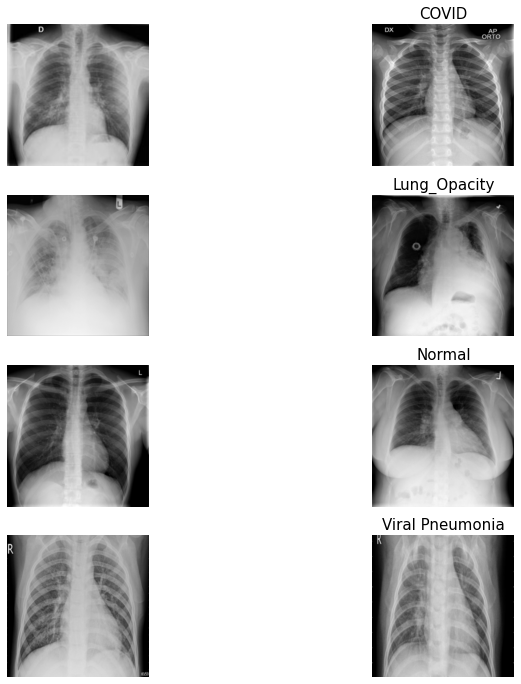

In [41]:
n_samples = 2

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['result']).groupby('result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [42]:
print('Normal : ', list(data['result']).count('Normal'))
print('Covid : ', list(data['result']).count('COVID'))
print('Opacity : ', list(data['result']).count('Lung_Opacity'))
print('Viral Pneumonia : ', list(data['result']).count('Viral Pneumonia'))

Normal :  10192
Covid :  3616
Opacity :  6012
Viral Pneumonia :  1345


In [43]:
round(data['result'].value_counts() / data.shape[0] * 100,2)

Normal             48.15
Lung_Opacity       28.41
COVID              17.08
Viral Pneumonia     6.35
Name: result, dtype: float64

In [44]:
pixel_img = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((1,64,64))
    pixel_img.append(img)

100%|██████████| 21165/21165 [00:58<00:00, 358.99it/s]


In [45]:
pixel_img = np.array(pixel_img)
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity' : 2,
                               'Viral Pneumonia' : 3})

print(pixel_img.shape, label_img.shape)

(21165, 1, 64, 64) (21165,)


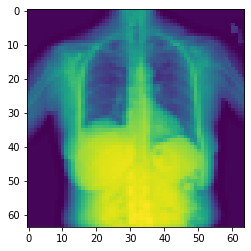

In [46]:
plt.imshow(pixel_img[200][0])

In [47]:
#20% will be used for test
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img, )
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16932, 1, 64, 64)
(4233, 1, 64, 64)
(16932,)
(4233,)


In [48]:
y_train = np.atleast_2d(y_train).reshape(-1,1)
y_test = np.atleast_2d(y_test).reshape(-1,1)

In [49]:
y_train.shape

(16932, 1)

In [52]:
def get_every_n(X, y, n=2):
    full_chunks_len = X.shape[0] // n
    for i in range(full_chunks_len):
        yield X[n*i:n*(i+1)], np.reshape(y[n*i:n*(i+1)], (1, -1))
    yield X[full_chunks_len*n:], np.reshape(y[full_chunks_len*n:,:], (1, -1))

In [56]:
start = timeit.default_timer()

#Your statements here
model = VGG16.CNN((2, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model.addLayer(VGG16.Conv_layer(kernel_size=3, n_kernels=16))
model.addLayer(VGG16.Pool_layer(2))
model.addLayer(VGG16.BatchNorm())
model.addLayer(VGG16.Conv_layer(kernel_size=3, n_kernels=8))
model.addLayer(VGG16.Pool_layer(2))
model.addLayer(VGG16.Reshape())
model.addLayer(VGG16.FullyConnected([10, 10], y_train.shape[1],VGG16.Tanh))
model.compile()
# model.forward(imgs)
for x, y in get_every_n(X_train, y_train, 2):
    print(x.shape)
    print(y.shape)
    model.train(x, y,X_test, y_test, 0.09, 5)
    break
stop = timeit.default_timer()
print('Time: ', stop - start)  
    

(2, 1, 64, 64)
(1, 2)
Pred:  (1, 2)
tar:  (1, 2)


MemoryError: Unable to allocate 2.07 GiB for an array with shape (4233, 16, 64, 64) and data type float64